# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names

- Kartik Bhatnagar
- Kai-Chin Shih 
- Sahana Srinivasan
- (Isaac) Fangzheng Xie 
- (Gin) Xiaojin Zheng 

# Group Members IDs

- A14020665
- A12879790
- A13741839
- A13768347
- A15674894

# Research Question

Are candidantes' trendiness on search engines, particularly Google, indicative of fundraising results?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis

Search engine trendiness figures positively correlate to campaign donorship.

# Dataset(s)

- Dataset 1 Name: BernieTrend.csv
- Link to the dataset: https://trends.google.com/trends/explore?q=%2Fm%2F01_gbv&geo=US
- Number of observations: 128 dates

- Dataset 2 Name: BernieTrend.csv
- Link to the dataset: https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00696948&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020
- Number of observations: 28170 transactions

- How we plan on combining datasets:

# Setup

In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

import shapely.geometry as shp

import sklearn.neighbors as skn
import sklearn.metrics as skm

pd.options.display.max_rows = 10

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
usa = gpd.read_file('./states_21basic/states.shp')

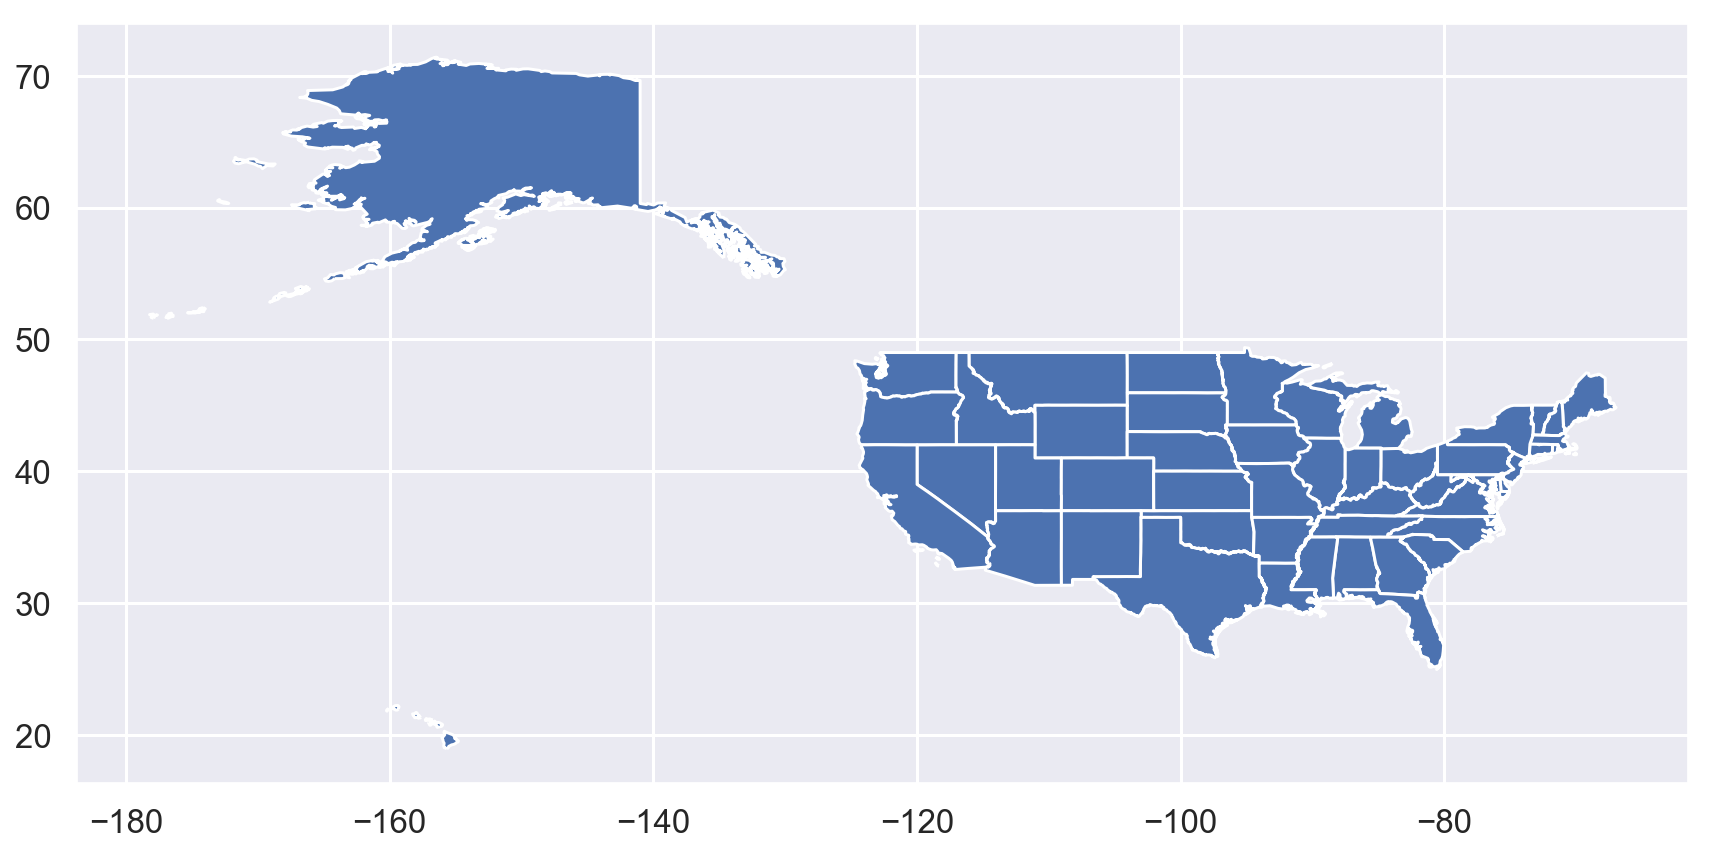

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(ax=ax, legend=True);

In [5]:
print(usa)

    STATE_NAME  DRAWSEQ STATE_FIPS          SUB_REGION STATE_ABBR  \
0       Hawaii        1         15             Pacific         HI   
1   Washington        2         53             Pacific         WA   
2      Montana        3         30            Mountain         MT   
..         ...      ...        ...                 ...        ...   
48     Florida       49         12      South Atlantic         FL   
49    Michigan       50         26  East North Central         MI   
50      Alaska       51         02             Pacific         AK   

                                             geometry  
0   (POLYGON ((-160.0738033454681 22.0041773479577...  
1   (POLYGON ((-122.4020153103835 48.2252163723779...  
2   POLYGON ((-111.4754253002074 44.70216236909688...  
..                                                ...  
48  (POLYGON ((-80.7856622716253 28.78519435427305...  
49  (POLYGON ((-88.49752727880752 48.1737953723300...  
50  (POLYGON ((-161.3337853466416 58.7332483821643...  

# Data Cleaning

In [6]:
dfBSTrend = pd.read_csv('bernietrend1.csv')
# keep date and trend
dfBSTrend.columns = ['date','trend']
# drop na
dfBSTrend = dfBSTrend.drop([0], axis = 0)
# change data type
dfBSTrend['trend'] = dfBSTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfBSTrend['date'] = dfBSTrend['date'].astype('datetime64')
dfBOTrend = pd.read_csv('betotrend1.csv')
dfBOTrend.columns = ['date', 'trend']
dfBOTrend = dfBOTrend.drop([0], axis = 0)
dfBOTrend['trend'] = dfBOTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfBOTrend['date'] = dfBOTrend['date'].astype('datetime64')
dfKHTrend = pd.read_csv('kamalatrend1.csv')
dfKHTrend.columns = ['date', 'trend']
dfKHTrend = dfKHTrend.drop([0], axis = 0)
dfKHTrend['trend'] = dfKHTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfKHTrend['date'] = dfKHTrend['date'].astype('datetime64')

Text(0.5, 1.0, 'Kamala Harris Trendiness')

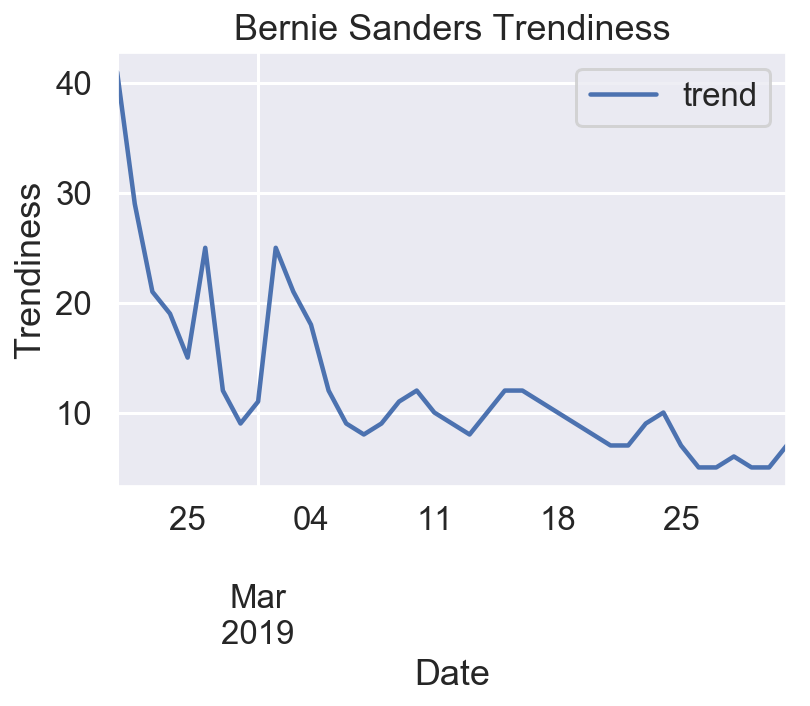

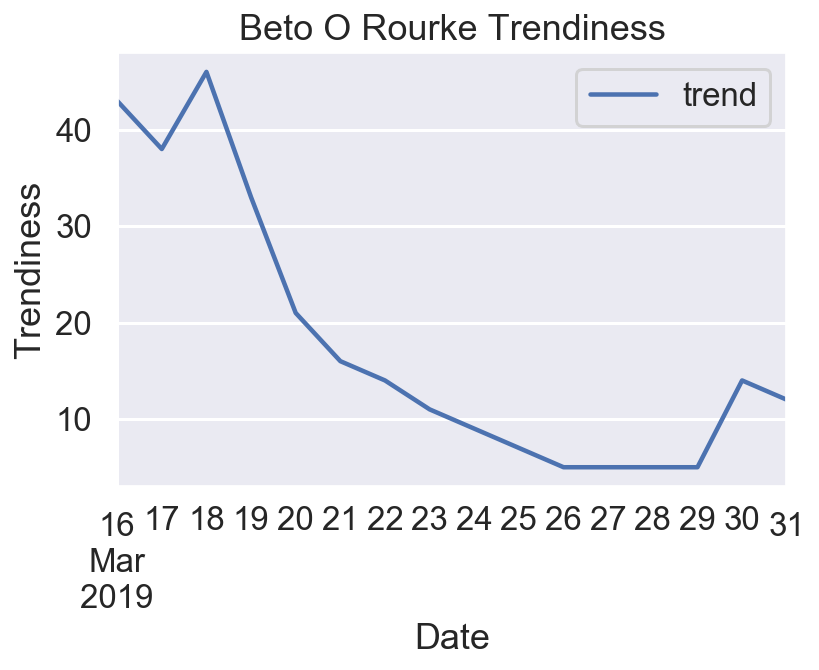

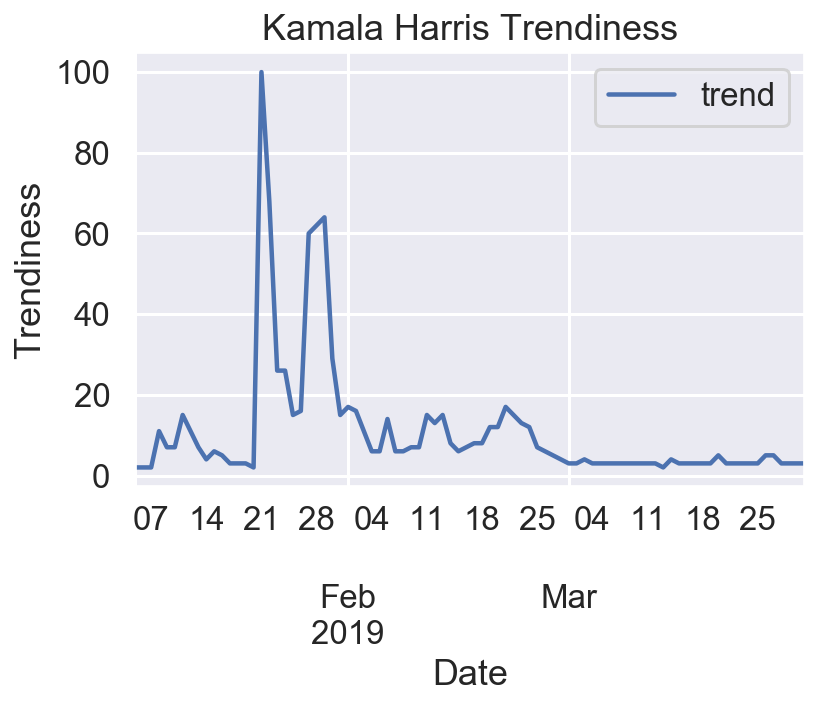

In [7]:
bernie = dfBSTrend.plot(x='date', y='trend')
bernie.set_xlabel('Date')
bernie.set_ylabel('Trendiness')
bernie.set_title('Bernie Sanders Trendiness')
beto = dfBOTrend.plot(x = 'date', y = 'trend')
beto.set_xlabel('Date')
beto.set_ylabel('Trendiness')
beto.set_title('Beto O Rourke Trendiness')
kamala = dfKHTrend.plot(x = 'date', y = 'trend') 
kamala.set_xlabel('Date')
kamala.set_ylabel('Trendiness')
kamala.set_title('Kamala Harris Trendiness')

In [18]:
dfBSFEC = pd.read_csv('FEC_Bernie2020.csv')
# keep certain columns
dfBSFEC = dfBSFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
# change data type
dfBSFEC['contribution_receipt_date'] = dfBSFEC['contribution_receipt_date'].astype("datetime64")
dfBSFEC['contribution_receipt_amount'] = dfBSFEC['contribution_receipt_amount'].apply(pd.to_numeric)
dfBOFEC = pd.read_csv('FEC_Beto2020.csv')
dfBOFEC = dfBOFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
dfBOFEC['contribution_receipt_date'] = dfBOFEC['contribution_receipt_date'].astype("datetime64")
dfBOFEC['contribution_receipt_amount'] = dfBOFEC['contribution_receipt_amount'].apply(pd.to_numeric)
dfKHFEC = pd.read_csv('FEC_Kamala2020.csv')
dfKHFEC = dfKHFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
dfKHFEC['contribution_receipt_date']= dfKHFEC['contribution_receipt_date'].astype("datetime64") 
dfKHFEC['contribution_receipt_amount'] = dfKHFEC['contribution_receipt_amount'].apply(pd.to_numeric)

Text(0.5, 1.0, 'Total Contribution Amount By Date to Harris')

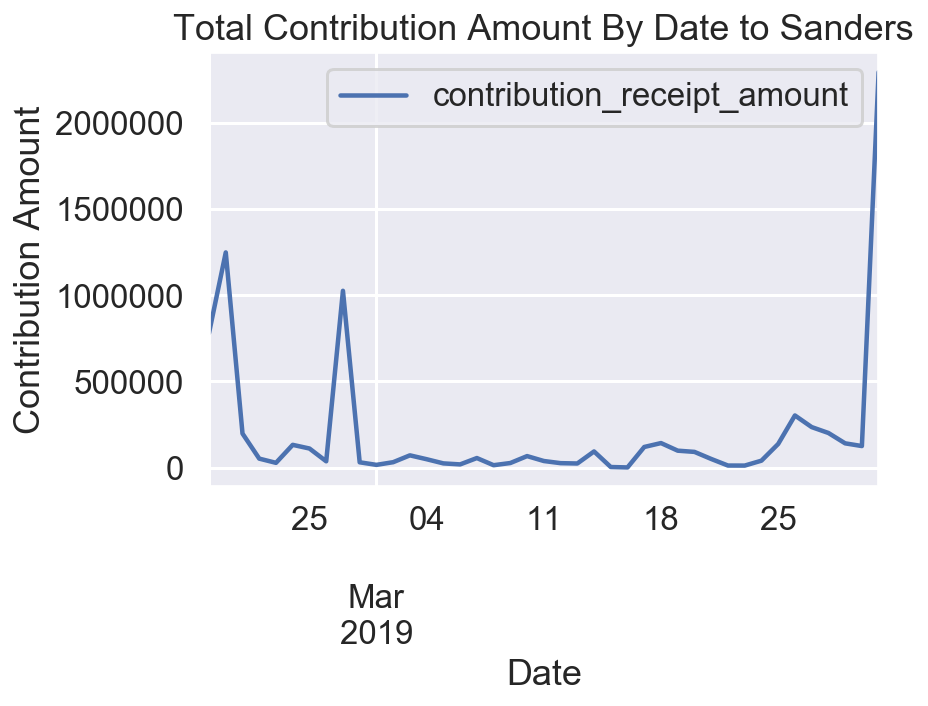

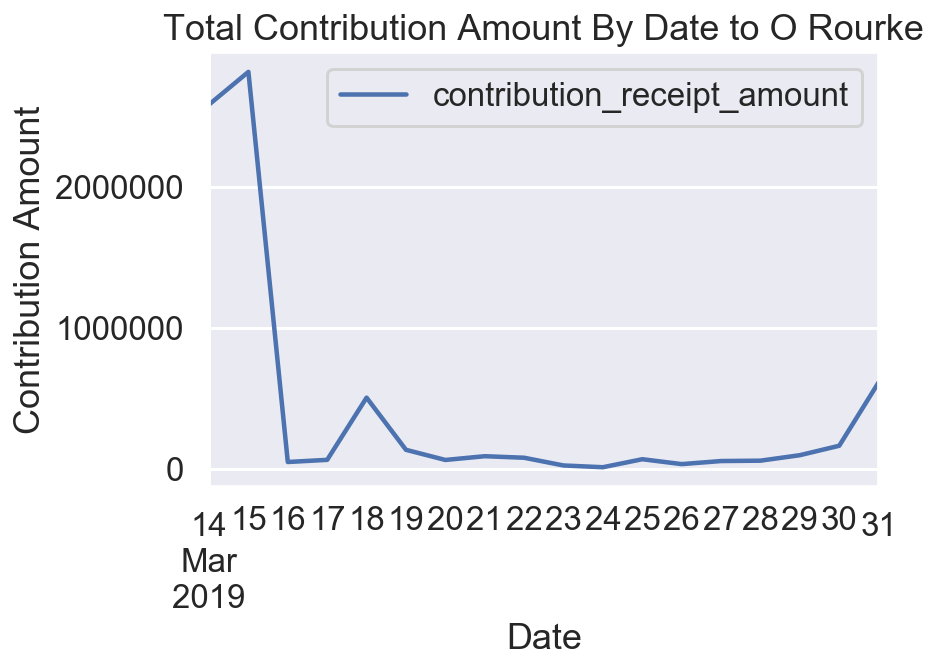

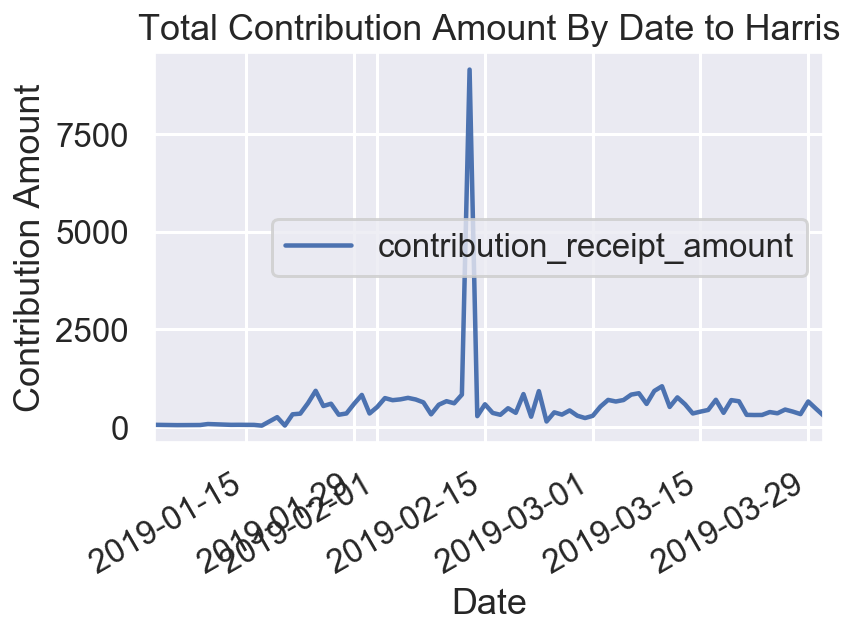

In [23]:
dfBSAmount = pd.pivot_table(dfBSFEC, index=['contribution_receipt_date'],values=["contribution_receipt_amount"],aggfunc=np.sum)
dfBSAmount.index.names = ['date']
bernie2 = dfBSAmount.plot()
bernie2.set_xlabel('Date')
bernie2.set_ylabel('Contribution Amount')
bernie2.set_title('Total Contribution Amount By Date to Sanders')
dfBOAmount = pd.pivot_table(dfBOFEC, index = ['contribution_receipt_date'], values = ["contribution_receipt_amount"], aggfunc = np.sum)
dfBOAmount.index.names = ['date']
beto2 = dfBOAmount.plot() 
beto2.set_xlabel('Date')
beto2.set_ylabel('Contribution Amount')
beto2.set_title('Total Contribution Amount By Date to O Rourke')
dfKHAmount = pd.pivot_table(dfKHFEC, index = ['contribution_receipt_date'], values = ["contribution_receipt_amount"])
kamala2 = dfKHAmount.plot()
kamala2.set_xlabel('Date')
kamala2.set_ylabel('Contribution Amount')
kamala2.set_title('Total Contribution Amount By Date to Harris')

In [ ]:
dfBSDonors = pd.pivot_table(dfBSFEC, index=['contribution_receipt_date'],values=["transaction_id"],aggfunc=lambda x: len(x.unique()))
dfBSDonors.index.names = ['date']
dfBSDonors.plot()
dfBODonors = pd.pivot_table(dfBOFEC, index = ['contribution_receipt_date'], values = ["transaction_id"], aggfunc = lamda x: len (x.unique()))

In [ ]:
dfBSStates = pd.pivot_table(dfBSFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
dfBSStates.index.names = ['state']
dfBSStates.plot()

In [ ]:
dfBSTrendStates = pd.read_csv('bernietrend_state.csv')
dfBSTrendStates.columns = ['state','trend']
dfBSTrendStates['trend'] = dfBSTrendStates['trend'].apply(pd.to_numeric, errors = 'coerce')
dfBSTrendStates = dfBSTrendStates.drop([0], axis = 0)
dfBSTrendStates = dfBSTrendStates.drop([1])
dfBSTrendStates

In [ ]:
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=dfBSTrendStates['trend'],ax=ax, legend=True);

# Data Analysis & Results

Correlation between interest over time and daily total donations

In [ ]:
merged = (pd.merge(dfBSAmount, dfBSTrend, how='outer', on='date'))
merged = merged.dropna()
ax = merged.plot('date','contribution_receipt_amount')
ax1 = ax.twinx()
merged.plot('date','trend',ax=ax1, color='r')

Correlation between interest over time and daily total transactions

In [ ]:
merged2 = (pd.merge(dfBSDonors, dfBSTrend, how='outer', on='date'))
merged2 = merged2.dropna()
ax = merged2.plot('date','transaction_id')
ax1 = ax.twinx()
merged2.plot('date','trend',ax=ax1, color='r')

Correlation between interest by state and total funds raised to-date by state

In [ ]:
merged3 = (pd.merge(dfBSStates, dfBSTrendStates, how='outer', on='state'))
merged3 = merged3.dropna()
ax = merged3.plot('state','contribution_receipt_amount')
ax1 = ax.twinx()
merged3.plot('state','trend',ax=ax1, color='r')

In [ ]:
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=merged3['contribution_receipt_amount'],ax=ax, legend=True);

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*